# Lane detection  - Naama and Gilad

When looking for a problem that interested us (Naama Shapira 318254240 and Gilad Ilani 307884098), we came to the conclusion that lane detection is something that interests us both. We went through several possibilities for this problem, with several different ideas on how to process the data, how to manipulate it and what information we can get from it. After a lot of deliberation we ultimately decided to go with the DET data set.
According to https://paperswithcode.com/sota/lane-detection-on-det, this dataset hasn't been used by any research except for the one how created and made first paper upon it.
We thought that with the advancement that accrued over the years, and with the fact that no one made any progress with this data since it was originals posted, that we can make feather progress with it. 

## About the problem:

Autonomous Vehicles are not a dream but a living fact. It will bring not only a great advance in global economy and life spend, but also an enormous leap in engineering in general and computer science in particular. Behind it's general idea relay countless problems which waiting to be solved, of already been solved: Object detecting, environment prediction, agent decision making and much more. We have decided to contributing to the solution of the lane detection problem. Altho we know of a lot of industry companies which has common solution to that problem, it is still considered as half-baked solution: most of the known models are failing in some edge cases and aren't dealing well with test datasets.

## About the data  - and why DVS:

DET dataset is a sires of 'photos' taken from a front camera of a moving car driving mostly on highways in the country of China.
We write 'photos' because it is not actually output of a camera but a senor called Dynamic Vision Sensor (DVS). It is an event-based sensor to lane which measure the changes in each pixar in 'light' it if it changed.
This simple process (we presented it simply, there are a few more things happens under the hood) is a great contributor to the lane dictation specificity and autonomous vehicles generally from a few reasons:

High frequency samples - DVS has can make much more samples in a given time, causing the data fed to the agent be much more updated.
Light and reflection resistance - most cameras which are used in current vehicles are reflected by the amount of light inserted to their sensor, when DVS is reflected from the change of the light. so a reflection from a window or a bright light from a crossing car can hurt the camera's ability to  get any info from the environment, while DVS will not.
Light data - since DVS output siriases of ones and zeros, each photo is much smaller in memory then a 3 dimensions, 255 colors image taken from regular photo, causing the whole calculation process to be much faster and lighter.

The dataset is available here: https://spritea.github.io/DET/

Example on an image taken using DVS:



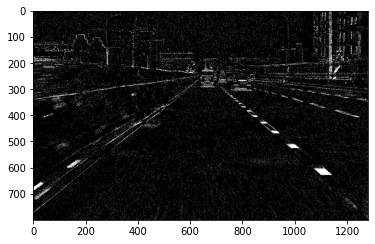

In [23]:
img = imread('./images/10.jpg')
plt.imshow(img)
plt.show()


## Cleaning the data:

In DET dataset, the DVS out put arrived as images and not as raw data. This caused some noise around each 'lighted' pixel.
Cleaning it was simple - iterating on each pixel - if it's lighter then grey - keep it, else - blank it.
This assured us that only true-white pixels remained.

In [1]:
!pip install numpy
!pip install opencv-python
%matplotlib inline

In [13]:
import numpy as np
from cv2 import imread, cvtColor, COLOR_BGR2GRAY, line
from matplotlib import pyplot as plt
from sklearn import linear_model

<Figure size 432x288 with 0 Axes>

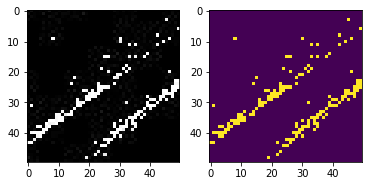

In [3]:
def delete_none_binary_pixels(img:np.ndarray):
    threshold = 240
    height, width = img.shape

    for i in range(height):
        for j in range(width):
            if img[i, j] > threshold:
                img[i, j] = 255
            else:
                img[i, j] = 0

    return img

img = imread('./images/757.jpg')
small = img[420:470,380:430,:]

gray = cvtColor(small, COLOR_BGR2GRAY)
binary = delete_none_binary_pixels(gray)
plt.figure()

f, axarr = plt.subplots(1,2) 
axarr[0].imshow(small)
axarr[1].imshow(binary)

plt.show()


Next thing to clean is the random points which are scattered all over the background in each photo. Those is noise from the actual sensor.
you can see in the right picture above that some of the points are separated from other group of point. we found them by checking their neighbors - if there aren't any' or only 1 - we blanked them.



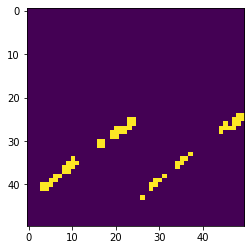

In [4]:
def delete_noise_by_neighbors(img:np.ndarray, kernel=[-1, 0, 1], min_neighbors_amount=3):
    height, width = img.shape
    out_img = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            if img[i, j] == 0:
                continue
            counter = 0
            for k in kernel:
                for m in kernel:
                    try:
                        if img[i + k, j + m] == 255:
                            counter += 1
                    except IndexError:
                        # kernel out of picture bound
                        pass
            # -1 ==> don't count a pixel as its own neighbor!
            if counter - 1 > min_neighbors_amount:
                out_img[i, j] = 255

    return out_img

only_grouped = delete_noise_by_neighbors(binary)

plt.imshow(only_grouped)
plt.show()


We combained our preprocess mehods into a general one:

In [5]:
def general(image_name:str, min_neighbors_amount_list = [2, 1])->np.ndarray:
    img = imread(image_name)
    img = cvtColor(img, COLOR_BGR2GRAY)
    img = delete_none_binary_pixels(img)
    for min_neighbor in min_neighbors_amount_list:
        img = delete_noise_by_neighbors(img, min_neighbors_amount=min_neighbor)
    return img

## Undestanding the dataset

We noticed that there are a few obsticals - noise that cannot be easly ignored, and that we needed to overcome in order to find the right lane. 
The main obsticals that were:
    
    1. Lanes that curv.
    2. Lanes that have things written on them or lines going across them.
    3. Other Cars that covers large part of the lane.
    4. Diffret road types, like stright lines.
    5. Lane change of the obsever's car.
 

Curv:


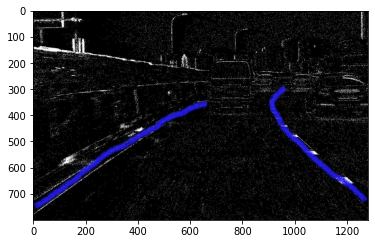

In [20]:
img = imread('./images/curv.png')
plt.imshow(img)
plt.show()


Words on road
<div>
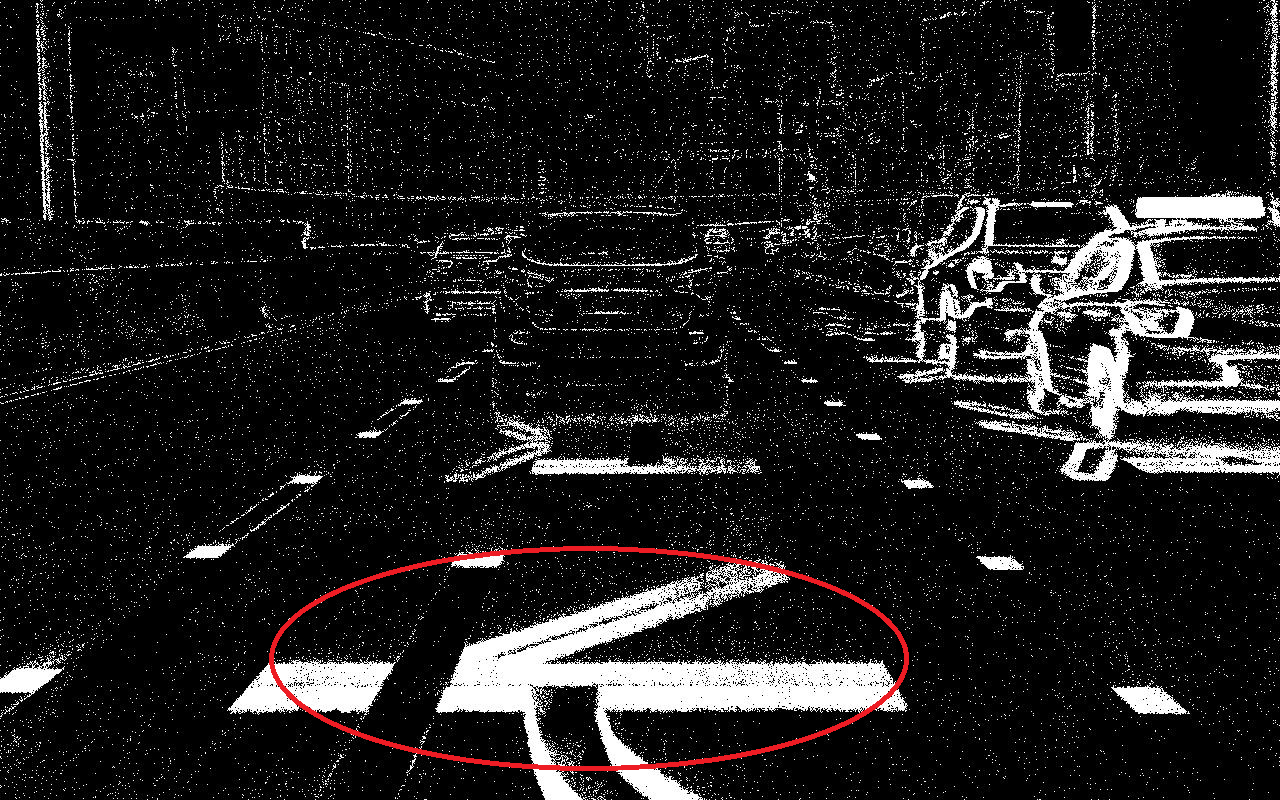
</div>



Line across road:
<div>
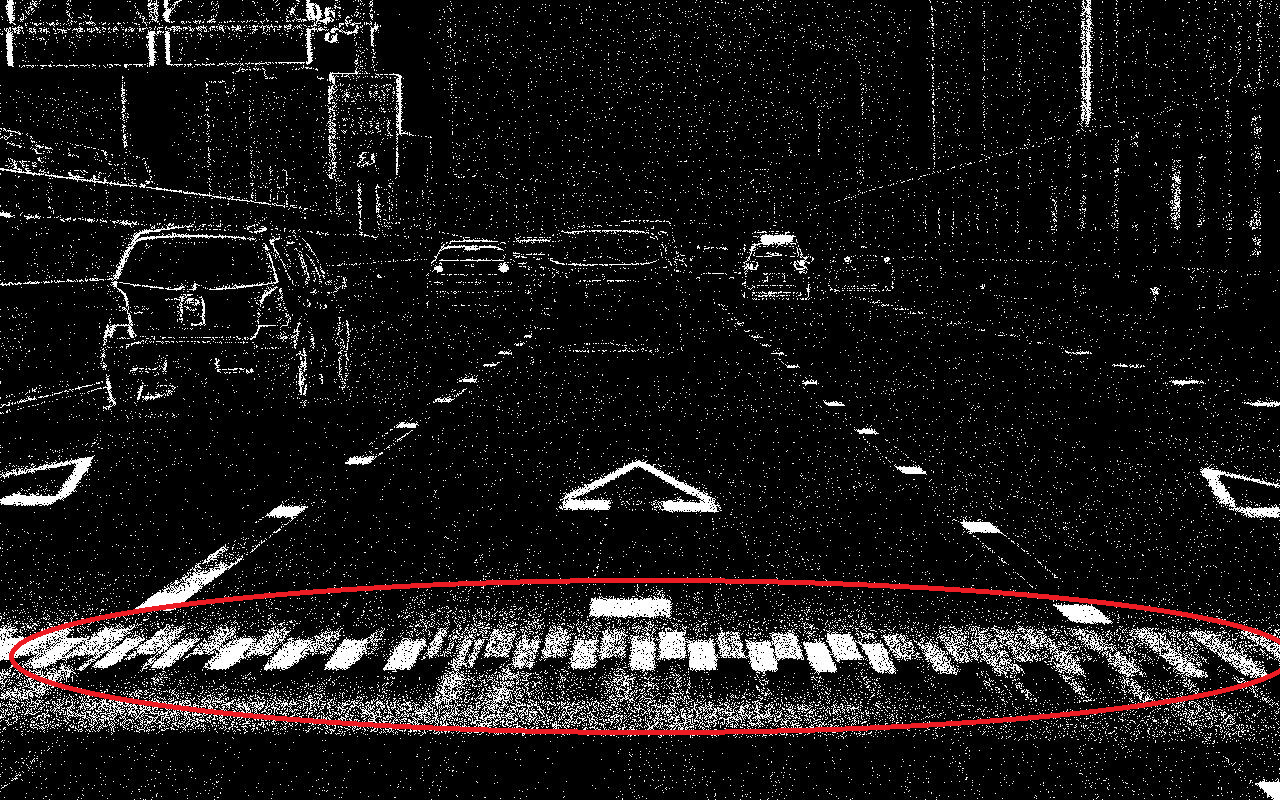
</div>


Diffrent road type:
<div>
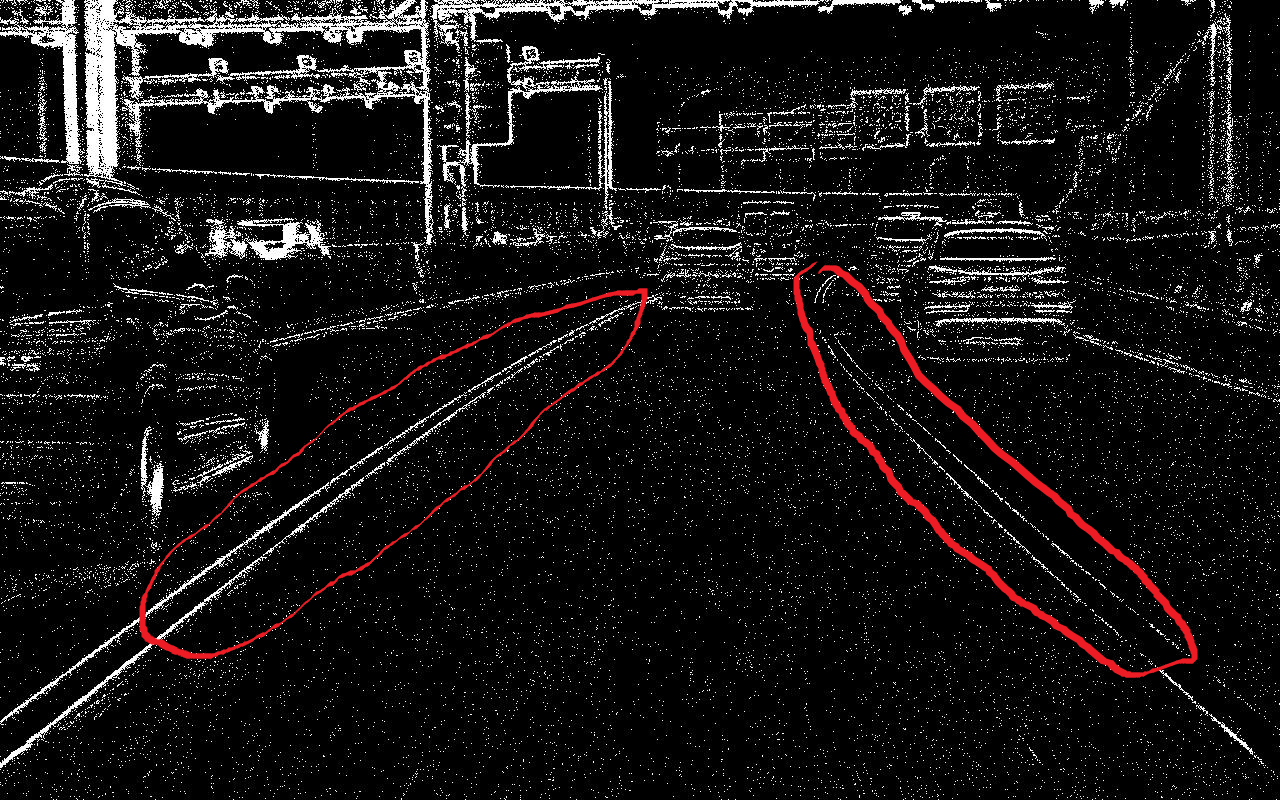
</div>


## Dividing a frame
Over all we could divide a general frame into a 3 interest sections:


<div>
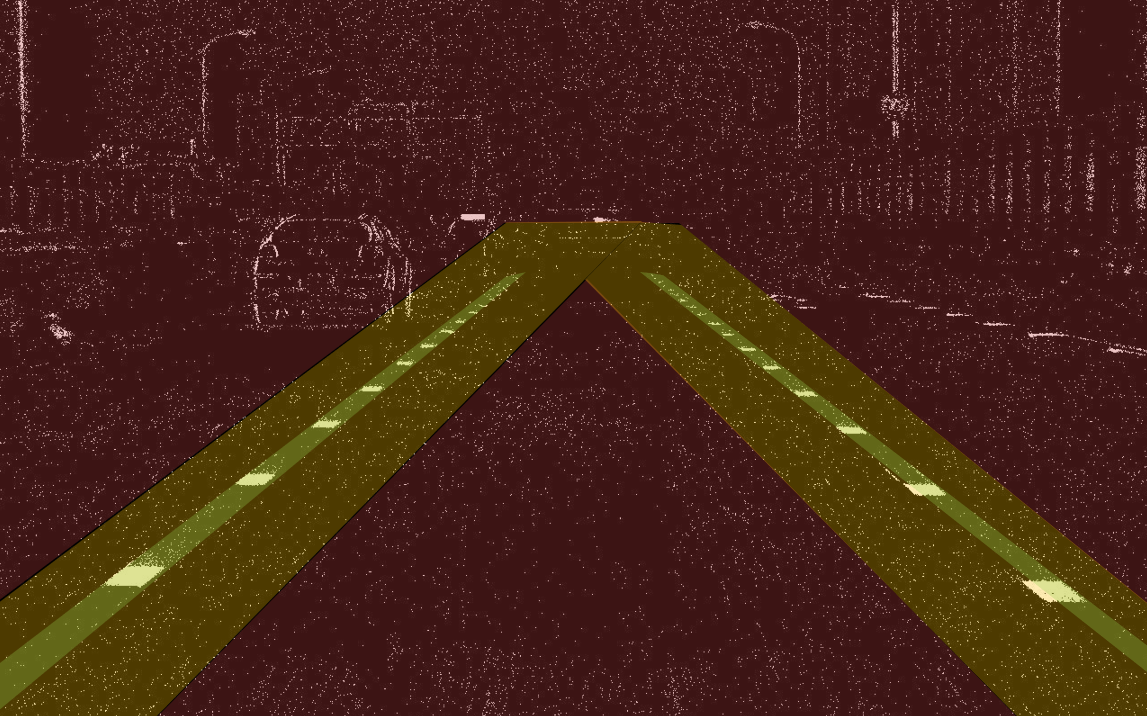
</div>

where Green is the target area, Red is the none-interest area - no even curved lanes arrive there, and Orange - the zone where the Green should be searched for.

This understanding narrows our search area a lot.


We do ignore the fact that the lane can be in the middle of the frame - when changing a lane. But the fact that it happens so little compare to the amount of the regular position, made us choose this hypothesis.

## Into the first solution

with prevues knowledge in mind, we started to look for common solution to find our lanes. 
A very known one is using hough transform. 

It is a very popular method to find lines which corresponds to a series of dots or lines.
Generally, it transform each point in space into a line, which called 'Hough space'. Then it find the spots with highest intersections amount. this spot is corresponding to a line in the original image.

When applied it on our data does manged to find the lines, but so does other lines.

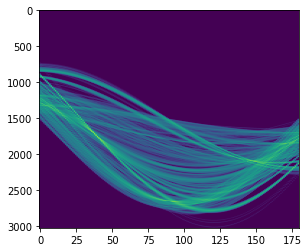

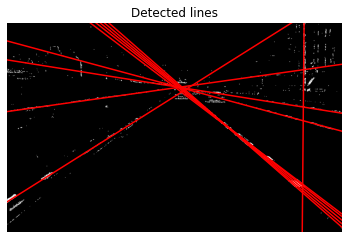

In [6]:
from skimage.transform import hough_line,hough_line_peaks

def all_hough_lines_transform(img):
    img = delete_none_binary_pixels(img)
    img = delete_noise_by_neighbors(img, min_neighbors_amount=2)

    img_unit8 = np.uint8(img)
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)
    h_space, theta, dist = hough_line(img_unit8, tested_angles)
    angle_list = []
    fig, axes = plt.subplots(1, 1)

    axes.imshow(np.log(1 + h_space), aspect=0.05)
    plt.show()
    fig, axes = plt.subplots(1, 1)
    axes.imshow(img, cmap='gray')

    origin = np.array((0, img.shape[1]))
    for _, angle, dist in zip(*hough_line_peaks(h_space, theta, dist)):
        angle_list.append(angle)
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        axes.plot(origin, (y0, y1), '-r')
    axes.set_xlim(origin)
    axes.set_ylim((img.shape[0], 0))
    axes.set_axis_off()
    axes.set_title('Detected lines')

    plt.show()


img = general('./images/10.jpg')    
all_hough_lines_transform(img)

We filtered to get only the lines which have the closes value to 0 and got a nice result:

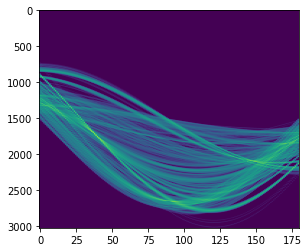

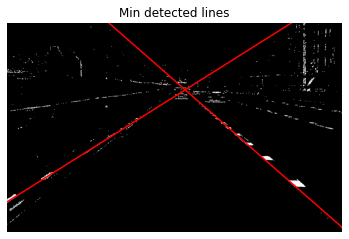

In [7]:
def hough_line_transform(img):
    img = delete_none_binary_pixels(img)
    img = delete_noise_by_neighbors(img, min_neighbors_amount=2)

    img_unit8 = np.uint8(img)
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180)
    h_space, theta, dist = hough_line(img_unit8, tested_angles)
    angle_list = []
    fig, axes = plt.subplots(1, 1)

    axes.imshow(np.log(1 + h_space), aspect=0.05)
    plt.show()
    fig, axes = plt.subplots(1, 1)
    axes.imshow(img, cmap='gray')

    origin = np.array((0, img.shape[1]))
    min_angels = [(9999, 0), (-9999, 0)]
    for _, angle, dist in zip(*hough_line_peaks(h_space, theta, dist)):
        if abs(angle) < 0.1:
            continue

        if 0 < angle < min_angels[0][0]:
            min_angels[0] = (angle, dist)
        elif min_angels[1][0] < angle < 0 and abs(abs(min_angels[0][0]) - abs(angle)) > 0.1:
            min_angels[1] = (angle, dist)

    for angle, dist in min_angels:
        angle_list.append(angle)
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        axes.plot(origin, (y0, y1), '-r')
    axes.set_xlim(origin)
    axes.set_ylim((img.shape[0], 0))
    axes.set_axis_off()
    axes.set_title('Min detected lines')

    plt.show()
    
hough_line_transform(img)

But this solution was not robust. It is only valid for spright roads, which is not our case.

From this little experiment we under stood that we need to divide our search into smaller parts, that way we can detect curves and not only straight lines. 

## Sliding window


we decided to take advantage of an obvious fact: the lines do start from the bottom corners of the screen in any case - curve or strign lanes. We can start in the corners and search where it is going to.

If we will set a small window in the corners of the frame, calculate the direction where it is going and repeat the process  - we will satisfy out strategy of dividing our search.

The search method we choose is by using RANSAC - a known algorithm which estimate a line from group of points by counting 'votes' from a suggested line. If a point is close enough to the line she votes for it, in she is now called 'inliner'. if a point is far from the lines she doest vote him and it is now called 'outliner'. 

It is much more suited to owr case becurse we have many lines and noise which will effect the line return from regular linear regressin, but in RANSAC will consider as outliner:

<div>
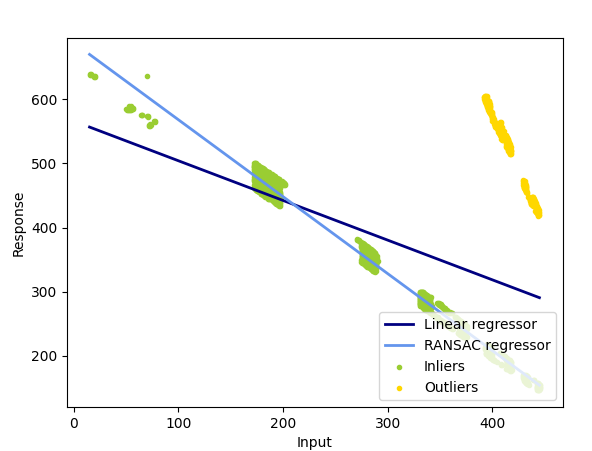
</div>

It is also more convenient then hough transform because for each window only one line is calculated - instead of the need to filter the most accurate line from each window, such as in the method earlier.

The first form that was select as a window was a rectangle, which gave the next algorithm:
In a given window the RANSAC was calculated and return a line which tell the direction of the lane. 
Then intersection of the height of the current window,and the new RANSAC line established a new point which is the bottom center of the next window. 

This method gave pretty good results. It is a pretty big code which is available in the repository, but here's the result:


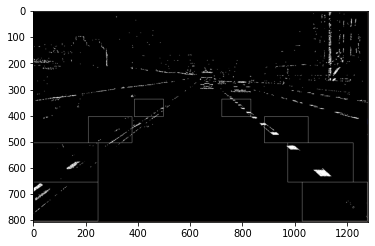

In [24]:
img = imread('./images/ractangles.jpeg')
plt.imshow(img)
plt.show()


## Improving the sliding window

As you can see in the above photo, some of the rectangles were covering a area which was considered 'Red'. 
We search for a shape which was equally easy to controll and calculate but covers erea in a more accuarate way. We choose Parlagrms for that. 
We defined it's upper and bottom edges as the rectangle  - parallel to the image upper and bottom edges, and tier location was calculated as a rectangle. The change was in the left and right edges that were given the angle as the RANSAC line before them. 

This algorithm implemented here. It's a pretty long code, you can navigate to the end to see the result.

This is the function which extract the points from first parallelograms:

In [8]:
def get_points_from_shape(img: np.ndarray, min_y, max_y, min_x, max_x, max_line, min_line):
    points = []
    for y in range(min_y, max_y):
        for x in range(min_x, max_x):
            if img[y, x] == 0:
                continue
            elif min_line(x) <= y <= max_line(x):
                points.append((x, y))
    return points

This is the function which manage the extraction the points from first parallelograms. They are calculated a bit different from the rest of the parallelogram becuase of the corners. This method has init params for thos parallelogram, it calculate them and draw them on the image.

In [9]:
def get_init_data(img: np.ndarray, par_height: int):
    height, width = img.shape

    m = -1.28
    n_1 = 650
    n_2 = 900

    def y_1(x): return m * x + n_1
    def x_2(y): return (y - n_2) / m
    def y_2(x): return m * x + n_2
    def x_1(y): return (y - n_1) / m

    upper_left = (int(x_1(height - par_height)), height - par_height)
    upper_right = (int(x_2(height - par_height)), height - par_height)
    bottom_right = (int(x_2(799)), 799)
    bottom_left = (0, int(y_1(0)))

    left_points = get_points_from_shape(
        img, height - par_height, height, 0, int(x_2(height - par_height)), y_2, y_1)

    line(img, upper_left, upper_right, 255, 1)
    line(img, upper_left, bottom_left, 255, 1)
    line(img, upper_right, bottom_right, 255, 1)

    
   ####################################################

    m = 1.28
    n_1 = -700
    n_2 = -950

    def x_1(y): return (y - n_1) / m
    def x_2(y): return (y - n_2) / m
    def y_1(x): return m * x + n_1
    def y_2(x): return m * x + n_2

    upper_left = (int(x_1(height - par_height)), height - par_height)
    bottom_left = (int(x_1(799)), 799)
    upper_right = (int(x_2(height - par_height)), height - par_height)
    bottom_right = (width, int(y_2(width)))

    right_points = get_points_from_shape(
        img, height - par_height, height, int(x_1(height - par_height)), width, y_1, y_2)

    line(img, upper_left, upper_right, 255, 1)
    line(img, upper_left, bottom_left, 255, 1)
    line(img, upper_right, bottom_right, 255, 1)

    return left_points, right_points


Here we want to get the information only found inside the parallelogram, that is so we can use that information in our regration.
We first create linear equations to set the sides of the parallelogram and then only take the data, limiting it to be inside the equeitions.


In [10]:
def get_data_from_parallelogram(img:np.ndarray, par):
    height, width = img.shape

    upper_left, bottom_right, par_width = par
    x_up_left, y_up = upper_left
    x_btm_right, y_btm = bottom_right

    x_up_right = x_up_left + par_width
    x_btm_left = x_btm_right - par_width

    left_line = set_linear_equation(upper_left, (x_btm_left, y_btm))
    right_line = set_linear_equation(bottom_right, (x_up_right, y_up))
    points = []

    for coordinate in [min(x_btm_left,x_up_left), max(x_btm_right,x_up_right)]:
        if coordinate is height or coordinate < 0:
            print('coordinate ' + str(coordinate) + ' out of bound!')
            return []

    for coordinate in [y_up, y_up]:
        if coordinate is width or coordinate < 0:
            print('coordinate ' +  str(coordinate) + ' out of bound!')            
            return []


    for y in range(y_up, y_btm):
        for x in range(min(x_btm_left,x_up_left),max(x_btm_right,x_up_right) ):
            try:
                if img[y, x] == 0:
                    continue
            except:
                pass
            else:
                if min(left_line(x),right_line(x)) <= y <= max(left_line(x),right_line(x)):
                    points.append((x, y))

    return points

def set_linear_equation(point_1, point_2):
    x_1, y_1 = point_1
    x_2, y_2 = point_2
    m = (y_2 - y_1)/(x_2 - x_1)
    n = y_1 - m*x_1
    return lambda x: m * x + n

def get_params_for_linear_equation(point_1, point_2):
    x_1, y_1 = point_1
    x_2, y_2 = point_2

    m = (y_2 - y_1)/(x_2 - x_1)   
    n = y_1 - m*x_1
    return  m , n


This is The utils function for the RANSAC calculation:

In [11]:
def get_par_from_points(par_width,  par_height, points, old_y):
    m, n = line_params_from_RANSAC(points)

    def linear_equation_by_y(y): return ((y-n) / m)

    new_upper_left, new_bottom_right = get_par_from_RANSAC_line(
        linear_equation_by_y, old_y, par_width, par_height)

    new_par = (new_upper_left, new_bottom_right, par_width, par_height)

    return new_par, (int(linear_equation_by_y(500)), old_y), (m, n)

def get_par_from_RANSAC_line(RANSAC_line_by_y, old_y_up: int, par_width: int, par_height: int):
    mid_btm_x = RANSAC_line_by_y(old_y_up)
    new_y_up = old_y_up - par_height

    mid_up_x = RANSAC_line_by_y(new_y_up)
    new_bottom_right = int(mid_btm_x + 0.5 * par_width), old_y_up
    new_upper_left = int(mid_up_x - 0.5 * par_width), new_y_up
    return new_upper_left, new_bottom_right


def line_params_from_RANSAC(points):
    # plot_RANSAC(points)
    x, y = zip(*points)

    y = np.asarray(y)
    x = np.array(x)[:, np.newaxis]

    ransac = linear_model.RANSACRegressor()
    ransac.fit(x, y)

    line_x = np.arange(x.min(), x.max())[:, np.newaxis]
    line_y = ransac.predict(line_x)
    y_0 = line_y[0]
    y_1 = line_y[1]

    x_0 = np.asscalar(line_x[0])
    x_1 = np.asscalar(line_x[1])

    m, n = get_params_for_linear_equation((x_1, y_1), (x_0, y_0))

    return m, n

This is a util function to draw parallelogram:

In [13]:
def draw_parallelogram(img:np.ndarray, par):
    height, width = img.shape
    upper_left, bottom_right, par_width = par
    x_up_left, y_up = upper_left
    x_btm_right, y_btm = bottom_right

    x_up_right = x_up_left + par_width
    x_btm_left = x_btm_right - par_width

    for coordinate in [x_up_left, x_up_right, x_btm_right, x_btm_left]:
        if coordinate is width or coordinate < 0:
            print ('coordinate is width:' + str(coordinate is width )+ ' width or coordinate < 0:' + str(width or coordinate < 0))
            return 


    for coordinate in [y_up, y_btm]:
        if coordinate is height or coordinate < 0:
            print('coordinate is height:' + str(coordinate is height)+'height or coordinate < 0:' + str(height or coordinate < 0))
            return 

    line(img, upper_left, (x_up_right, y_up), 255, 1)
    line(img, upper_left, (x_btm_left, y_btm), 255, 1)
    line(img, bottom_right, (x_up_right, y_up), 255, 1)
    line(img, bottom_right, (x_btm_left, y_btm), 255, 1)

This is the loop which run on each parallelogram. after init, for every parallelogram it's extrac it's points, gets the linear equation by the RANSAC and calculate next parallelogram. in the end it store all it's data in lists.

In [14]:
def calc_pars(img: np.ndarray, first_points,  par_width: int, par_height: int, old_y: int, total_par_amount=2):
    par_width_delta = 0.7
    par_height_delta = 0.5
    first_calc_par, first_estimated_point, line_params = get_par_from_points(
        int(par_width * par_width_delta),  int(par_height * par_height_delta), first_points, old_y)

    line_list = [line_params]
    par_list = [first_calc_par]
    estimated_points = [first_estimated_point]
    for i in range(total_par_amount - 1):

        old_par = par_list[-1]

        upper_left, bottom_right, current_par_width, current_par_height = old_par
        _, y_up = upper_left

        points = get_data_from_parallelogram(
            img, (upper_left, bottom_right, current_par_width))
        if len(points) is 0:
            print('len(points) is 0:')
            m, n = line_list[-1]
        else:
            m, n = line_params_from_RANSAC(points)

        def linear_equation_by_y(y): return ((y-n) / m)

        new_par_width = int(current_par_height * par_width_delta)
        new_par_height = int(current_par_width * par_height_delta)

        new_upper_left, new_bottom_right = get_par_from_RANSAC_line(
            linear_equation_by_y, y_up, new_par_width, new_par_height)

        estimated_points.append((int(linear_equation_by_y(y_up)), y_up))
        par_list.append((new_upper_left, new_bottom_right,
                        new_par_width, new_par_height))
    #  add last point
    estimated_points.append(
        (int(linear_equation_by_y(new_upper_left[1])), new_upper_left[1]))

    return par_list, estimated_points

This is the main methods which init the process for each line and return the location of the middle of the parallelogram:

In [15]:
def main_par_regression_loop(img_path='images/10.jpg', par_height=300, par_width=100):

    img = general(img_path, min_neighbors_amount_list=[2, 1])

    first_y = 500

    left_points, right_points = get_init_data(img, par_height)

    left_par_list, left_estimated_points = calc_pars(
        img, left_points, par_width, par_height, first_y)

    right_par_list, right_estimated_points = calc_pars(
        img, right_points,   par_width, par_height, first_y)

    for par in left_par_list:
        upper_left, bottom_right, par_width, par_height = par
        draw_parallelogram(img, (upper_left, bottom_right, par_width))

    for par in right_par_list:
        upper_left, bottom_right, par_width, par_height = par
        draw_parallelogram(img, (upper_left, bottom_right, par_width))

    plt.imshow(img)
    plt.show()
    print('Left estimated points:', left_estimated_points)
    print('Right estimated points:', right_estimated_points)
    return left_estimated_points, right_estimated_points



And here's the final result:

c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()
c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()
c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.ite

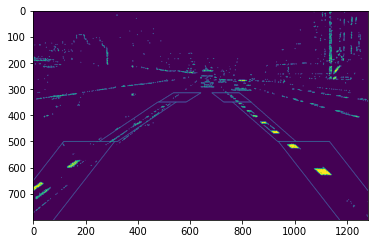

Left estimated points: [(288, 500), (533, 350), (588, 315)]
Right estimated points: [(969, 500), (780, 350), (735, 315)]


([(288, 500), (533, 350), (588, 315)], [(969, 500), (780, 350), (735, 315)])

In [16]:
main_par_regression_loop()

And lastly, after finding the points of the lanes, we found the curve that goes through them. This curve represents the lane, and after finding both curve, one for each side of the lane, we added them on to the image.

In [23]:

def find_func(points_l,points_r, image):
    x_l = []
    y_l = []
    x_r = []
    y_r = []
    for p in points_l:
        x_l.append(p[0])
        y_l.append(800-p[1])
    for p in points_r:
        x_r.append(p[0])
        y_r.append(800-p[1])
    middle =(min(x_r) + max(x_l))/2
    func_l = np.polyfit(x_l, y_l, 2)
    fx_l = np.linspace(0,middle, 800)
    fy_l = np.polyval(func_l, fx_l)
    func_r = np.polyfit(x_r, y_r, 2)
    fx_r = np.linspace(middle , 1280, 800)
    fy_r = np.polyval(func_r, fx_r)
    im = plt.imread(image)
    fig, ax = plt.subplots()
    ax.imshow(im, extent=[0, 1280, 0, 800])
    ax.plot(fx_l, fy_l, '-', color='red')
    ax.plot(fx_r, fy_r, '-', color='green')
    plt.show()

c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()
c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  
c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  app.launch_new_instance()
c:\Users\Gilad\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.ite

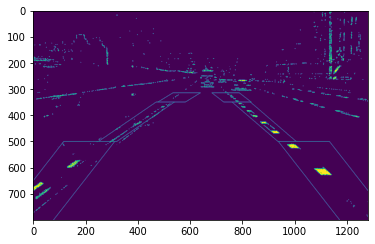

Left estimated points: [(285, 500), (530, 350), (586, 315)]
Right estimated points: [(970, 500), (780, 350), (735, 315)]


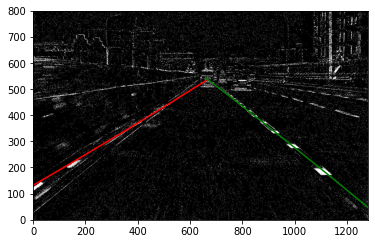

In [24]:
left_points, right_points = main_par_regression_loop()
find_func(left_points, right_points, 'images/10.jpg')

## Conclusion

We need tyo make a big disclaimer about this algorithm. Yes as you see it works for this dataset, but the biggest issue we had is the running time. If our goal in to use this method in a real car, it's running time should be milliseconds and not seconds!
For that we need to implement the code on a faster language, maybe c++, and make a lot of optimizations to different parts of the algorithm.

